<a href="https://colab.research.google.com/github/deinal/graph-forecast/blob/main/graph_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Forecast

In [1]:
!nvidia-smi

Fri Nov 24 08:45:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.__version__

'2.1.0+cu118'

In [ ]:
!pip install torch_geometric

## Data

Simulation of a dynamic graphs where nodes appear, move, and disappear over time

### Node initialization
- Each node is initialized with a random angle and radius, determining its position in the 2D `xy` plane
- The `z` coordinate is initialized to 0
- Node types are determined based on their quadrant in the Cartesian plane and are one-hot encoded
- Three edges are created between nodes and their closest neighbors

### Node movement and removal
- Nodes move in a spiral pattern, incrementing their `z` coordinate over time
- When a node's `z` coordinate exceeds 1, it is marked for removal
- Empty nodes are assigned type -1
- A new node is added after a two timestep delay at the previously stored `xy` position with `z` reset to 0


### Edge attributes
- An adjacency matrix is used to track the existence of links between node pairs
- This matrix generates edge attributes for link prediction tasks

### Data object
- For each time step, a `Data` object is created containing node features, edge indices, node types, and edge attributes

### Parameters
- `node_count`: The number of nodes in the graph
- `time_steps`: The number of time steps for the simulation
- `min_nodes` and `max_nodes`: The minimum and maximum number of active nodes at any given time step
- `all_pairs`: All possible pairs of nodes for link prediction, excluding self-links


In [4]:
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from tqdm.notebook import tqdm

In [5]:
def one_hot_encode(types, num_classes=5):
    types[types == -1] = num_classes - 1
    return np.eye(num_classes)[types].reshape(-1, num_classes)

def generate_node_type(xy):
    types = np.zeros((xy.shape[0], 1), dtype=int)
    for i in range(xy.shape[0]):
        if xy[i, 0] >= 0 and xy[i, 1] >= 0:
            types[i] = 0  # +x+y
        elif xy[i, 0] >= 0 and xy[i, 1] < 0:
            types[i] = 1  # +x-y
        elif xy[i, 0] < 0 and xy[i, 1] >= 0:
            types[i] = 2  # -x+y
        else:
            types[i] = 3  # -x-y
    return types

def initialize_node():
    angle = np.random.rand() * 2 * np.pi  # Random angle
    radii = np.sqrt(np.random.rand())  # Uniform distribution within circle
    xy = np.array([radii * np.cos(angle), radii * np.sin(angle)])
    new_type = generate_node_type(xy.reshape(1, -1))[0, 0]
    z = np.array([0])
    type_encoded = one_hot_encode(np.array([new_type]))
    node_data = np.hstack((xy, z, type_encoded.reshape(-1)))
    return node_data, new_type

def create_edge_attr_for_pairs(edge_index, num_nodes, all_pairs):
    # Create adjacency matrix
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
    for edge in edge_index.T:
        adjacency_matrix[edge[0], edge[1]] = 1
        adjacency_matrix[edge[1], edge[0]] = 1  # Assuming undirected graph

    # Extract the existence of link for each pair in all_pairs
    link_true = adjacency_matrix[all_pairs[:, 0], all_pairs[:, 1]]
    return link_true

def generate_spiral(node_count, time_steps, min_nodes=5, max_nodes=10):
    data_list = []
    stored_xy = [None] * node_count
    total_node_count = node_count

    # Initialize node features and types for the first time step using initialize_node function
    x = np.array([initialize_node()[0] for _ in range(node_count)])
    original_types = x[:, 3:3+1].astype(int)  # Extract types from initialized node data

    # Calculate initial xy_radius and z_hop
    xy_radius = np.sqrt(x[:, 0]**2 + x[:, 1]**2)
    z_hop = 0.05 - xy_radius / 21

    # Track when to add new nodes
    add_node_timers = np.zeros(node_count, dtype=int)

    # Initialize an empty edge list
    edge_list = []

    for t in range(time_steps):
        # Recalculate num_existing and non_removed_nodes at the start of each loop
        num_existing = np.count_nonzero(original_types != -1)
        non_removed_nodes = original_types[:, 0] != -1

        # Update node coordinates for non-removed nodes
        x[non_removed_nodes, 2] += z_hop[non_removed_nodes]
        theta = 2 * np.pi * (t / 50) # Circle movement
        normalized_xy_radius = np.minimum(xy_radius[non_removed_nodes], 1)
        x[non_removed_nodes, 0] = normalized_xy_radius * np.cos(theta)
        x[non_removed_nodes, 1] = normalized_xy_radius * np.sin(theta)

        # Check for nodes to remove
        for i in range(node_count):
          if x[i, 2] > 1 and original_types[i] != -1:
              # Store xy coordinates before removal
              stored_xy[i] = x[i, :2].copy()

              # Node exceeds z, mark for removal
              x[i][2] = 0
              original_types[i] = -1
              add_node_timers[i] = 2 # Small delay
              num_existing -= 1
              edge_list = [edge for edge in edge_list if i not in edge]

        # Add new nodes if timer is up
        for i in range(node_count):
            if add_node_timers[i] > 0:
                add_node_timers[i] -= 1
                if add_node_timers[i] == 0 and num_existing < max_nodes:
                    if stored_xy[i] is not None:
                        # Use stored xy coordinates and reset z to 0
                        xy = stored_xy[i]
                        z = 0
                        new_type = generate_node_type(xy.reshape(1, -1))[0, 0]
                    else:
                        # Initialize new node as usual
                        node_data, new_type = initialize_node()
                        xy, z = node_data[:2], node_data[2]

                    type_encoded = one_hot_encode(np.array([new_type]))
                    x[i] = np.hstack((xy, z, type_encoded.reshape(-1)))
                    original_types[i] = new_type
                    num_existing += 1
                    xy_radius[i] = np.sqrt(xy[0]**2 + xy[1]**2)
                    z_hop[i] = 0.05 - xy_radius[i] / 21

                    # Calculate edges for the new node (excluding self-edge)
                    if num_existing > 1:
                        existing_nodes = np.where(original_types != -1)[0]
                        dist_to_existing = np.linalg.norm(x[existing_nodes, :3] - x[i, :3], axis=1)
                        closest_nodes = existing_nodes[np.argsort(dist_to_existing)]
                        # Exclude self and take the next two closest nodes
                        closest_nodes = closest_nodes[closest_nodes != i][:3]
                        for closest in closest_nodes:
                            edge_list.append([i, closest])

        # Create edge_index from edge_list
        edge_index = np.array(edge_list).T if edge_list else np.empty((2, 0), dtype=int)

        # Create data object
        data = Data(x=torch.tensor(x, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
        data.type = torch.tensor(original_types, dtype=torch.long)

        # Create binary links
        all_pairs = torch.combinations(torch.arange(node_count), r=2)
        data.edge_attr = create_edge_attr_for_pairs(data.edge_index, node_count, all_pairs)

        data_list.append(data)

    return data_list

def split_data(data_list, train_ratio=0.8):
    total_snapshots = len(data_list)
    train_size = int(total_snapshots * train_ratio)
    train_data = data_list[:train_size]
    test_data = data_list[train_size:]
    return train_data, test_data

# Generate data
node_count = 10
time_steps = 2000
data_list = generate_spiral(node_count, time_steps)
all_pairs = torch.combinations(torch.arange(node_count), r=2)

# Split data into train and test
train_data, test_data = split_data(data_list, train_ratio=0.9)

In [6]:
test_data[3].edge_attr

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 1.])

In [7]:
test_data[3].type

tensor([[3],
        [1],
        [1],
        [1],
        [2],
        [0],
        [0],
        [3],
        [3],
        [0]])

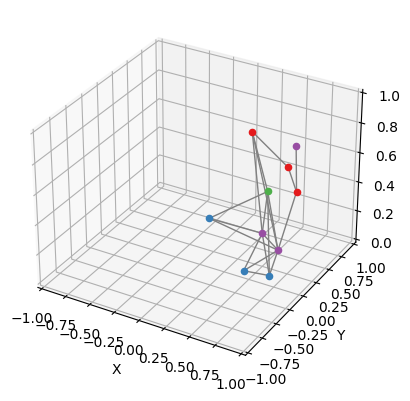

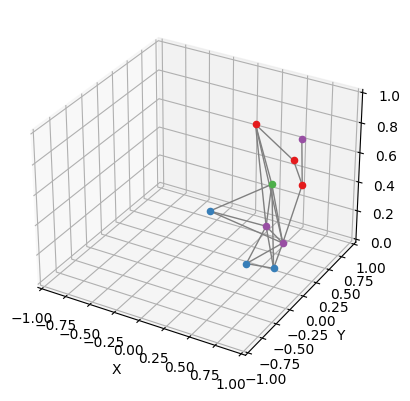

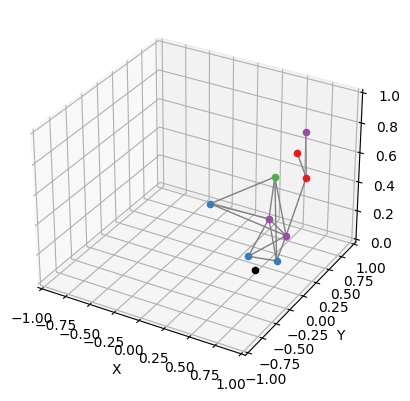

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_graph_3d(data, time_step):
    G = nx.Graph()
    node_types = data[time_step].type.numpy()
    pos = {i: (data[time_step].x[i, 0].item(), data[time_step].x[i, 1].item(), data[time_step].x[i, 2].item()) for i in range(data[time_step].num_nodes)}

    G.add_nodes_from(pos.keys())
    for i, j in data[time_step].edge_index.T.tolist():
        G.add_edge(i, j)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for key, value in pos.items():
        xi, yi, zi = value
        node_type = node_types[key][0]
        color = 'black' if node_type == -1 else plt.cm.Set1(node_type)
        ax.scatter(xi, yi, zi, color=color)

    for i, j in G.edges():
        x = np.array((pos[i][0], pos[j][0]))
        y = np.array((pos[i][1], pos[j][1]))
        z = np.array((pos[i][2], pos[j][2]))
        ax.plot(x, y, z, color='gray', lw=1)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


for i in range(3):
  plot_graph_3d(test_data, i)

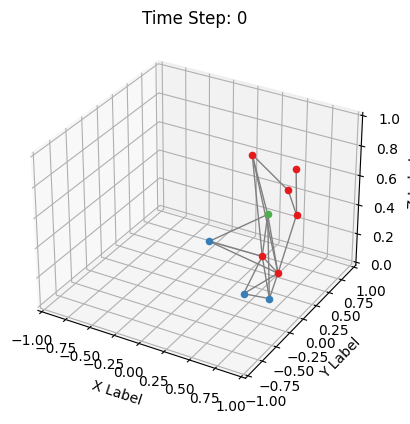

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

colors = plt.cm.Set1((0, 1, 2))

def update_graph(num, data, graph, ax):
    ax.clear()
    G = nx.Graph()
    pos = {i: (data[num].x[i, 0].item(), data[num].x[i, 1].item(), data[num].x[i, 2].item()) for i in range(data[num].num_nodes)}

    G.add_nodes_from(pos.keys())
    for i, j in data[num].edge_index.T.tolist():
        G.add_edge(i, j)

    for key, value in pos.items():
        xi, yi, zi = value
        node_type = int(data[num].type[key])
        color = 'black' if node_type == -1 else colors[node_type % len(colors)]
        ax.scatter(xi, yi, zi, color=color)

    for i, j in G.edges():
        x = np.array((pos[i][0], pos[j][0]))
        y = np.array((pos[i][1], pos[j][1]))
        z = np.array((pos[i][2], pos[j][2]))
        ax.plot(x, y, z, color='gray', lw=1)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title(f'Time Step: {num}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ani = FuncAnimation(fig, update_graph, frames=20, fargs=(test_data, nx.Graph(), ax))
HTML(ani.to_jshtml())

## Model

### Architecture

- **Graph Attention Layers (GATConv)**: Utilizes attention mechanisms to weigh the importance of neighboring nodes
- **Normalization Layers (GraphNorm)**: Applies normalization to the output of GAT layers
- **Fully Connected Layers**: Three separate fully connected layers for predicting node coordinates (`fc_coords`), node types (`fc_type`), and future links (`fc_link_pred`)

### Forward Pass
- Sequential processing through GAT and normalization layers with GELU activation functions
- Concatenation of node features from GAT layers to form the input for fully connected layers
- Predicts node coordinates (x, y, z) and node types (class logits)
- Pairwise node feature concatenation for link prediction, linear layer to predict binary link logits

In [10]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GraphNorm

In [11]:
class GraphPredictor(torch.nn.Module):
    def __init__(self, node_features, hidden_dim, coord_features, num_classes):
        super(GraphPredictor, self).__init__()

        self.layers = torch.nn.ModuleList()
        self.norm_layers = torch.nn.ModuleList()

        self.layers.append(GATConv(node_features, hidden_dim[0], add_self_loops=True))
        self.norm_layers.append(GraphNorm(hidden_dim[0]))

        for in_dim, out_dim in zip(hidden_dim[:-1], hidden_dim[1:]):
            self.layers.append(GATConv(in_dim, out_dim, add_self_loops=True))
            self.norm_layers.append(GraphNorm(out_dim))

        self.fc_coords = torch.nn.Linear(hidden_dim[-1], coord_features)
        self.fc_type = torch.nn.Linear(hidden_dim[-1], num_classes)

        self.fc_link_pred = torch.nn.Linear(hidden_dim[-1] * 2, 1)

    def forward(self, x, edge_index, all_pairs, edge_weight=None):
        for layer, norm in zip(self.layers, self.norm_layers):
            x = layer(x, edge_index, edge_weight)
            x = norm(x)
            x = F.gelu(x)

        coords = self.fc_coords(x)
        node_type_logits = self.fc_type(x)

        pair_features = torch.cat([x[all_pairs[:, 0]], x[all_pairs[:, 1]]], dim=1)
        link_logits = self.fc_link_pred(pair_features).squeeze()

        return coords, node_type_logits, link_logits

## Training

In [12]:
def perform_prediction(model, data, time_step, all_pairs, loss_functions, is_train=True):
    historical_features = [data[time_step - h].x for h in range(history_length, 0, -1)]
    current_features = data[time_step].x
    combined_features = torch.cat(historical_features + [current_features], dim=1)

    coords_true = data[time_step + 1].x[:, :3]
    type_true = data[time_step + 1].x[:, 3:]
    link_true = data[time_step + 1].edge_attr

    if is_train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    with torch.set_grad_enabled(is_train):
        coords_pred, type_logits, link_pred_logits = model(combined_features, data[time_step].edge_index, all_pairs)

        mse_loss = loss_functions['mse'](coords_pred, coords_true)
        ce_loss = loss_functions['ce'](type_logits, type_true)
        link_pred_loss = loss_functions['bce'](link_pred_logits, link_true)
        total_loss = mse_loss + ce_loss + link_pred_loss

        if is_train:
            total_loss.backward()
            optimizer.step()

    return mse_loss.item(), ce_loss.item(), link_pred_loss.item(), total_loss.item()

In [13]:
def move_data(data_list, device):
    for data in data_list:
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.edge_attr = data.edge_attr.to(device) if data.edge_attr is not None else None
    return data_list

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
num_epochs = 50
history_lengths = [0, 1, 2]
coord_features = 3
num_classes = 5
hidden_dim = [32, 64, 128]

train_data = move_data(train_data, device)
test_data = move_data(test_data, device)

loss_functions = {
    'mse': torch.nn.MSELoss(),
    'ce': torch.nn.CrossEntropyLoss(),
    'bce': torch.nn.BCEWithLogitsLoss()
}

all_history_results = {
    'train_node_mse': {},
    'train_node_ce': {},
    'train_link_bce': {},
    'train_total': {},
    'test_node_mse': {},
    'test_node_ce': {},
    'test_link_bce': {},
    'test_total': {}
}

for history_length in history_lengths:
    model = GraphPredictor(
        node_features=(coord_features + num_classes) * (1 + history_length),
        hidden_dim=hidden_dim,
        coord_features=coord_features,
        num_classes=num_classes,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    mse_losses, ce_losses, link_pred_losses, total_losses = [], [], [], []
    test_mse_losses, test_ce_losses, test_link_pred_losses, test_total_losses = [], [], [], []

    for epoch in tqdm(range(num_epochs), desc=f'History Length {history_length}'):
        mse_loss_epoch, ce_loss_epoch, link_pred_loss_epoch, total_loss_epoch = 0, 0, 0, 0

        for time in range(history_length, len(train_data) - 1):
            mse_loss, ce_loss, link_pred_loss, total_loss = perform_prediction(
                model, train_data, time, all_pairs, loss_functions, is_train=True)
            mse_loss_epoch += mse_loss
            ce_loss_epoch += ce_loss
            link_pred_loss_epoch += link_pred_loss
            total_loss_epoch += total_loss

        mse_losses.append(mse_loss_epoch / len(train_data))
        ce_losses.append(ce_loss_epoch / len(train_data))
        link_pred_losses.append(link_pred_loss_epoch / len(train_data))
        total_losses.append(total_loss_epoch / len(train_data))

        # Testing loop for each epoch
        test_mse_loss_epoch, test_ce_loss_epoch, test_link_pred_loss_epoch, test_total_loss_epoch = 0, 0, 0, 0
        for time in range(history_length, len(test_data) - 1):
            test_mse_loss, test_ce_loss, test_link_pred_loss, test_total_loss = perform_prediction(
                model, test_data, time, all_pairs, loss_functions, is_train=False)
            test_mse_loss_epoch += test_mse_loss
            test_ce_loss_epoch += test_ce_loss
            test_link_pred_loss_epoch += test_link_pred_loss
            test_total_loss_epoch += test_total_loss

        test_mse_losses.append(test_mse_loss_epoch / len(test_data))
        test_ce_losses.append(test_ce_loss_epoch / len(test_data))
        test_link_pred_losses.append(test_link_pred_loss_epoch / len(test_data))
        test_total_losses.append(test_total_loss_epoch / len(test_data))

    all_history_results['train_node_mse'][history_length] = mse_losses
    all_history_results['train_node_ce'][history_length] = ce_losses
    all_history_results['train_link_bce'][history_length] = link_pred_losses
    all_history_results['train_total'][history_length] = total_losses
    all_history_results['test_node_mse'][history_length] = test_mse_losses
    all_history_results['test_node_ce'][history_length] = test_ce_losses
    all_history_results['test_link_bce'][history_length] = test_link_pred_losses
    all_history_results['test_total'][history_length] = test_total_losses

History Length 0:   0%|          | 0/50 [00:00<?, ?it/s]

History Length 1:   0%|          | 0/50 [00:00<?, ?it/s]

History Length 2:   0%|          | 0/50 [00:00<?, ?it/s]

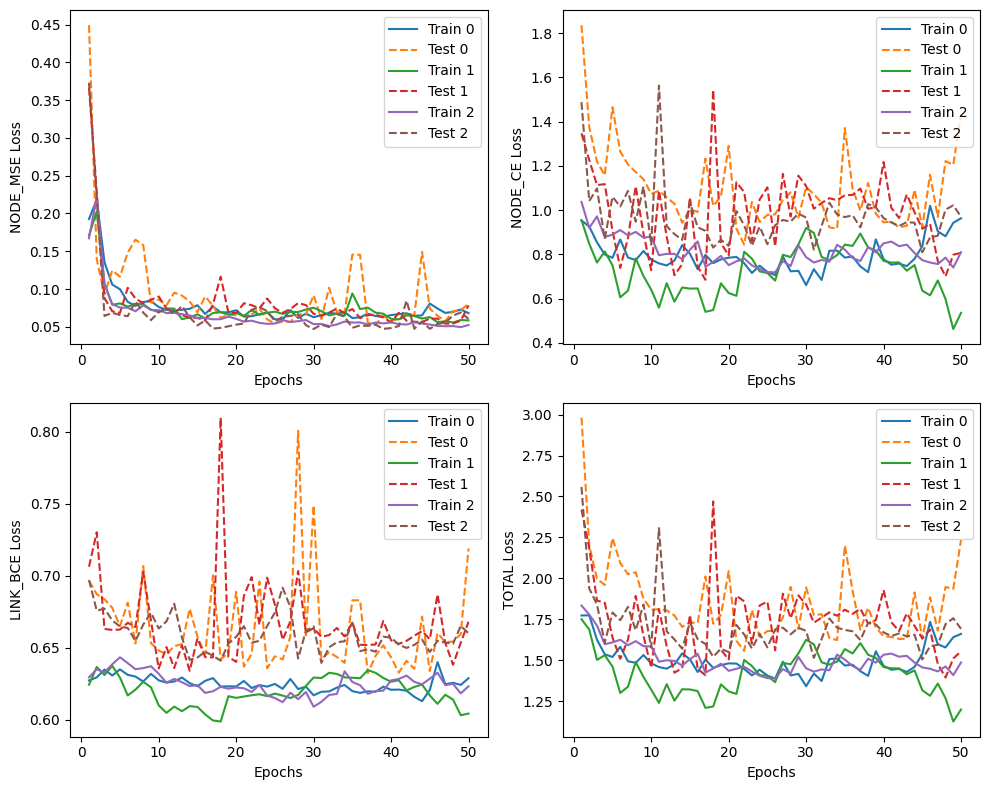

In [16]:
# Losses for different history lengths

plt.figure(figsize=(10, 8))

for i, metric in enumerate(['node_mse', 'node_ce', 'link_bce', 'total']):
    plt.subplot(2, 2, i+1)
    for history_length in history_lengths:
        train_losses = all_history_results[f'train_{metric}'][history_length]
        test_losses = all_history_results[f'test_{metric}'][history_length]
        plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train {history_length}')
        plt.plot(range(1, num_epochs + 1), test_losses, label=f'Test {history_length}', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric.upper()} Loss')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Predictions

In [54]:
dataset = test_data
autoregressive = False
use_predicted_edges = False

model.to('cpu').eval()
dataset = move_data(dataset, 'cpu')

predictions = []

for time in tqdm(range(history_length, len(dataset) - 1)):
    if time == 0 or autoregressive == False:
        historical_features = [dataset[time - h].x for h in range(history_length, 0, -1)]
    with torch.no_grad():
        if time == history_length or autoregressive == False:
            current_features = dataset[time].x
            current_edge_index = dataset[time].edge_index
            combined_features = torch.cat(historical_features + [current_features], dim=1)
        else:
            # Use the previous prediction as the current input
            prev_coords_pred, prev_type_logits, _ = predictions[-1]
            current_features = torch.cat((prev_coords_pred, prev_type_logits), dim=1)
            link_probs = torch.sigmoid(predictions[-1][2])
            predicted_edges = (link_probs > 0.5).nonzero(as_tuple=False)
            if use_predicted_edges:
                current_edge_index = all_pairs[predicted_edges].T
            else:
                current_edge_index = dataset[time].edge_index

            # Update historical features
            historical_features.pop(0)
            historical_features.append(current_features)

            # Recombine features for the next prediction
            combined_features = torch.cat(historical_features + [current_features], dim=1)

        # Predict the next state
        coords_pred, type_logits, link_pred_logits = model(combined_features, current_edge_index, all_pairs)

        # Append the prediction to the list
        predictions.append((coords_pred, type_logits, link_pred_logits))

  0%|          | 0/1797 [00:00<?, ?it/s]

In [55]:
torch.sigmoid(predictions[0][2]).numpy()

array([0.5470809 , 0.5239424 , 0.5699713 , 0.33694592, 0.46724144,
       0.3316984 , 0.5107553 , 0.3238596 , 0.5594051 , 0.5061615 ,
       0.55244106, 0.32122898, 0.44956768, 0.31610954, 0.49295858,
       0.3084691 , 0.5417904 , 0.5971656 , 0.36239144, 0.49517825,
       0.35696104, 0.5386633 , 0.34883678, 0.5867831 , 0.3000805 ,
       0.42526352, 0.29515153, 0.46830443, 0.2878045 , 0.51718515,
       0.2233801 , 0.13999067, 0.25505593, 0.13576204, 0.29398534,
       0.271393  , 0.43929464, 0.26441547, 0.4879261 , 0.33152628,
       0.18536574, 0.37623265, 0.3575909 , 0.5960427 , 0.30147967],
      dtype=float32)

In [56]:
def plot_graph_3d(data, ax, is_prediction=False, all_pairs=None):
    G = nx.Graph()
    if is_prediction:
        coords, type_logits, link_pred_logits = data
        node_types = torch.argmax(type_logits, dim=1).numpy()
        pos = {i: (coords[i, 0].item(), coords[i, 1].item(), coords[i, 2].item()) for i in range(len(coords))}

        edge_probs = torch.sigmoid(link_pred_logits).numpy()
        threshold = 0.4
        for i, (pair, prob) in enumerate(zip(all_pairs, edge_probs)):
            if prob > threshold:
                G.add_edge(pair[0].item(), pair[1].item())
    else:
        node_types = data.type.numpy()
        pos = {i: (data.x[i, 0].item(), data.x[i, 1].item(), data.x[i, 2].item()) for i in range(data.num_nodes)}
        for i, j in data.edge_index.T.tolist():
            G.add_edge(i, j)

    G.add_nodes_from(pos.keys())
    for key, value in pos.items():
        xi, yi, zi = value
        node_type = node_types[key] if is_prediction else node_types[key][0]
        color = 'black' if node_type == -1 else colors[node_type % len(colors)]
        ax.scatter(xi, yi, zi, color=color)

    for i, j in G.edges():
        x = np.array((pos[i][0], pos[j][0]))
        y = np.array((pos[i][1], pos[j][1]))
        z = np.array((pos[i][2], pos[j][2]))
        ax.plot(x, y, z, color='gray', lw=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-1.25, 1.25])
    ax.set_ylim([-1.25, 1.25])
    ax.set_zlim([0, 1.25])

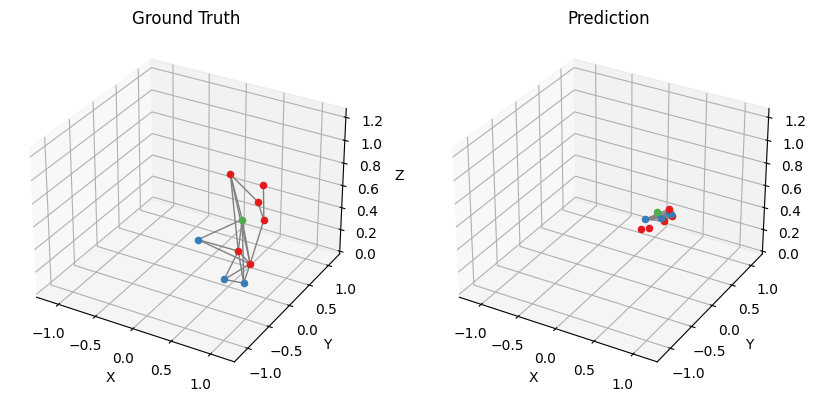

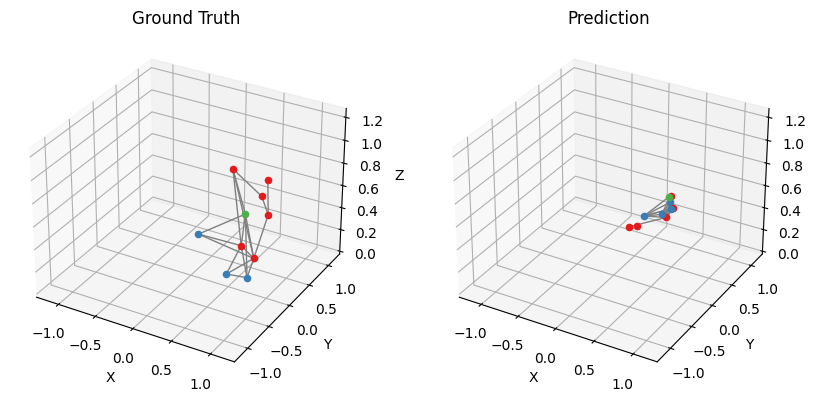

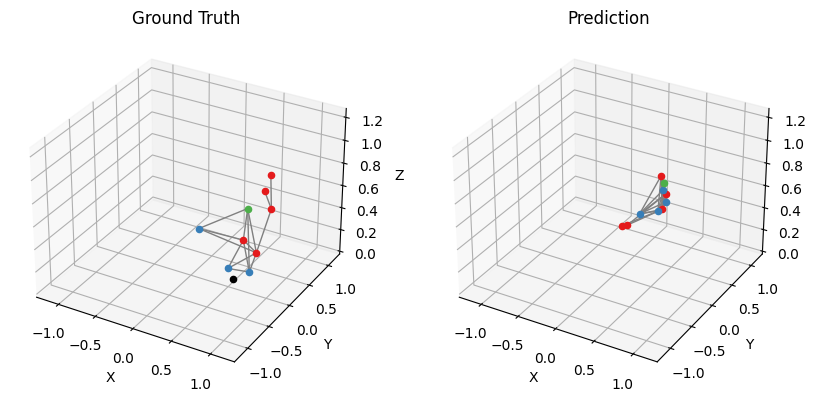

In [57]:
def plot_comparison_3d(ground_truth_data, predicted_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 5))

    plot_graph_3d(ground_truth_data, ax1)
    ax1.set_title('Ground Truth')

    plot_graph_3d(predicted_data, ax2, is_prediction=True, all_pairs=all_pairs)
    ax2.set_title('Prediction')

    plt.show()

for i in range(3):
    plot_comparison_3d(test_data[i], predictions[i])

In [58]:
def update_graph(num, test_data, predictions, all_pairs, ax1, ax2):
    ax1.clear()
    ax2.clear()
    plot_graph_3d(test_data[num], ax1)
    plot_graph_3d(predictions[num], ax2, is_prediction=True, all_pairs=all_pairs)
    ax1.set_title('Ground Truth')
    ax2.set_title('Prediction')
    fig.suptitle(f'Timestep: {num}')

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

num_frames = 50  # len(predictions)

ani = FuncAnimation(fig, update_graph, frames=num_frames,
                    fargs=(test_data, predictions, all_pairs, ax1, ax2),
                    interval=1000, repeat=True)

ani.save('predictions.gif', writer='pillow', fps=7)
plt.close(fig)

## Discussion

- GAT is meant for a static graph, so empty nodes must be treated carefully
- Past timesteps with different topology cannot either be processed properly
- For changing graphs [EvolveGCN](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html#torch_geometric_temporal.nn.recurrent.evolvegcno.EvolveGCNO) or other Dynamic Graph Nets are an option
- If empty nodes can be treated using a special class label the graph could be processed statically like here, history can be incorporated with a spatio-temporal gnn such as [AAGCN](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html#torch_geometric_temporal.nn.attention.tsagcn.AAGCN)
- If links are unimportant for the task, e.g. fully connected is better, then there are options such as [EdgeConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.EdgeConv.html#torch_geometric.nn.conv.EdgeConv) or [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)